# CONTROLLING CANCER WITH VITAMINS
(Based on a final project submitted by Jacob Evarts to BIOEN 599, March, 2024, University of Washington)

# Preliminaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import control
import controlSBML as ctl
import tellurium as te

# Helpers

In [2]:
TIMES = np.linspace(0, 30, 300)
FIGSIZE = (5, 5)

In [3]:
def calculate_r_squared(tf_df: pd.DataFrame, target="Normal_cells") -> float:
    """
    Calculate the R-squared value for the actual and predicted values.
    
    Args:
        tf_df : pandas.DataFrame
            DataFrame returned by the plotTransferFunctionFit method.
    
    Returns:
        float
            R-squared value.
    """
    actual = tf_df.loc[:, [target]].values
    predicted = tf_df.loc[:, ["predicted"]].values

    mean_actual = np.mean(actual)
    ss_total = np.sum((actual - mean_actual) ** 2)
    ss_residual = np.sum((actual - predicted) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    
    return r_squared

# 1. Problem statement & system definition

Cancer and its causes is a field that has recieved much attention, and mitigating the chance of cancer with lifestyle changes is ideal over other more invasive treatments. [This model](https://www.ebi.ac.uk/biomodels/BIOMD0000001042#Overview) investigates how the consumptions of vitamins in the diet affects the progression of a tumor in a healthy cell context. The authors claim that different combinations of vitamins can keep healthy cells alive where they would otherwise be wiped out by the tumor cell population. Therefore, the model input is vitamins and the output species of interest are healthy and tumor cells. The control objectives will be:
1. Maximize healthy cell growth over the vitamin treatement.
    - This will result in decreasing tumor cells because of competition.
2. Minimize oscilations, as population collapse and rebound is not ideal in a living system.
3. The vitamin operating range will be [0, 10] (high levels of vitamins could be incur unacceptable levels of toxicity).

If these objectives can be achieved it would give insight into a dietary intervention for cancer that could be prevent more serious later stage cases.

## System Exploration

Here we explore the relationship between the key entities in the model: tumor cells, normal cells, and vitamins.

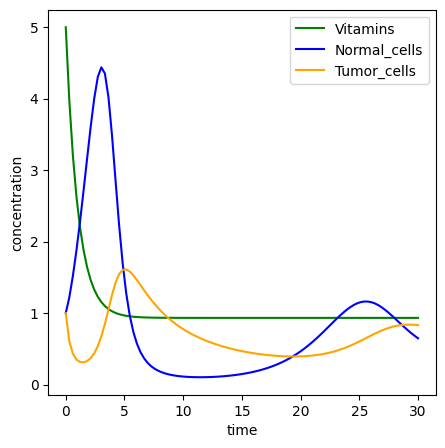

In [4]:
url = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL2108260003/3/Alharbi2019%20TNVM.xml"
CTLSB = ctl.ControlSBML(url, times=np.linspace(0, 30, 100), is_fixed_input_species=True)
_ = CTLSB.plotModel(figsize=FIGSIZE, selections=["Normal_cells", "Tumor_cells", "Vitamins"])

These plots are not controlled experiments and so it's difficult to see the relationship between vitamins and normal cells. For example, the dramatic drop in vitamins *may* becausing the increase in healthy cells. But we need another study to make this connection.

## Staircase response for healthy cells

The staircase response provides a constant influx of vitamins at different levels to assess the impact on the population of normal cells.

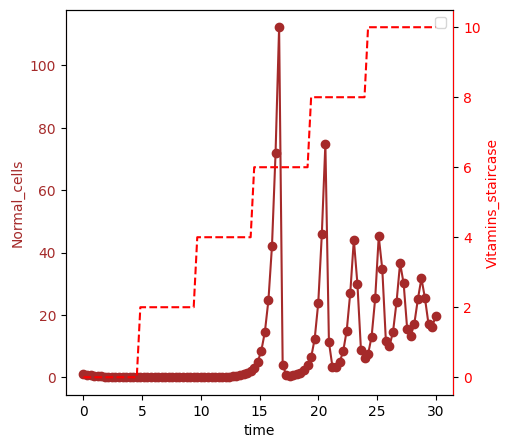

In [5]:
CTLSB.setSystem(input_name="Vitamins", output_name="Normal_cells", is_fixed_input_species=True)
_ = CTLSB.plotStaircaseResponse(initial_value=0, final_value=10, figsize=FIGSIZE)

In [6]:
# Constants based on staircase response
TIMES = np.linspace(0, 200, 2000)
INITIAL_VALUE = 2
FINAL_VALUE = 6

INPUT = "Vitamins"
OUTPUT = "Normal_cells"

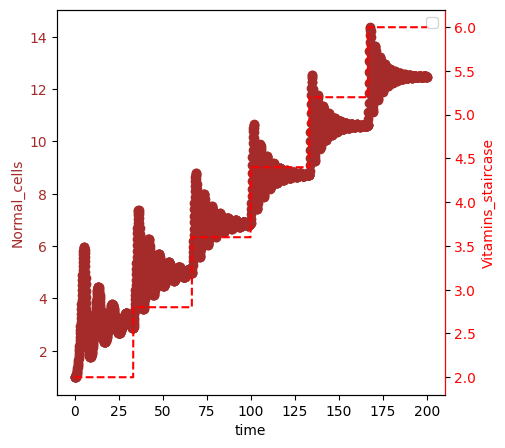

In [7]:
CTLSB = ctl.ControlSBML(url, times=TIMES, input_name=INPUT, output_name=OUTPUT, is_fixed_input_species=True,
                       figsize=FIGSIZE)
_ = CTLSB.plotStaircaseResponse(initial_value=INITIAL_VALUE, final_value=FINAL_VALUE)

# 2. System definition

A system is defined by its inputs, outputs, the range of their values, and how the input affects the output.

1. SBML model: https://www.ebi.ac.uk/biomodels/services/download/getfiles/MODEL2108260003/3/Alharbi2019%20TNVM.xml

2. Output: Normal_cells

3. Input: Vitamins

4. Direction effect of input: Increasing oscilatory 

5. Operating region: [2, 6]

6. Range of outputs that can be achieved: [0, 5.5]

Both cell types have similar responses to stepping up the vitamin concentration. It is worth noting that with a static vitamin concentration of 0, the healthy cells will completely die out and the cancer cells will propagate. It appears that when vitamin concentration increases there is an initial growth of healthy cells, which after a short lag is followed by the growth of tumor cells. With this in mind it would be interesting to try a series of vitamin interventions as opposed to keeping the level constant, which would also better represent the real effects of eating meals over time with vitamins. 

# 3. System identification

System identification is a curve fitting procedure that constructs a transfer function that relates values of the input to those of the output. As before, we use a staircase of input values.

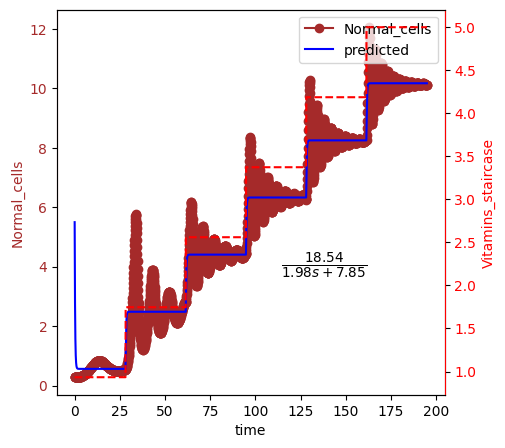

In [8]:
results = CTLSB.plotTransferFunctionFit(num_zero=0, num_pole=2, fit_start_time=5, figsize=FIGSIZE,
                                       times=TIMES, fitter_method="poly")
rsq1 = calculate_r_squared(results[0])
TRANSFER_FUNCTION_1 = CTLSB.getOpenLoopTransferFunction()

The default number of zeros and poles of the transfer function provide a credible fit to the results simulated by the SBML model. However, it is worth testing a simpler and more complex model as well. Also, we want to do curve fitting after the initial transients have settled, about time 50.

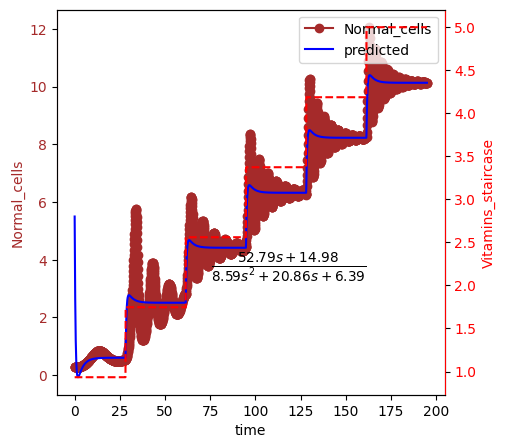

In [9]:
results = CTLSB.plotTransferFunctionFit(num_zero=1, num_pole=3, fit_start_time=5, times=TIMES,
                                       figsize=FIGSIZE)
rsq2 = calculate_r_squared(results.timeseries)
TRANSFER_FUNCTION_2 = CTLSB.getOpenLoopTransferFunction()

We can quantitatively measure the fit of the line using the $R^2$ values

In [10]:
print(f"Medium model R-squared: {rsq1}")
print(f"Complex model R-squared: {rsq2}")


Medium model R-squared: 0.9623593506192629
Complex model R-squared: 0.9632048541058623


Since the two models provide equally good fits, we choose the model with lower complexity.

In [11]:
print(TRANSFER_FUNCTION_1.poles())

[-3.15920808e+05+0.j -3.96603520e+00+0.j]


Here we can see the system should converge relatively slowly, but there are imagniary parts which is why we see the initial oscilations in the staircase plots.

# 4. Control design

## Testbed construction

We can construct the closed loop system and plot the result.

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]


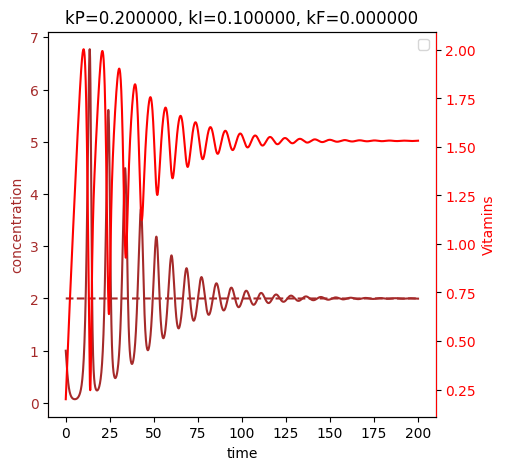

In [12]:
_ = CTLSB.plotDesign(setpoint=2, kP_spec=0.2, kI_spec=0.1, min_parameter_value=1,
                max_parameter_value=100, num_restart=1 )

Of the six reactions that take place in this model, they are all either synthesis or degradation reactions. It is interesting to not the coupling between the tumor and normal cell growth equations. In particular, healthy cells decrease as a function of healthy cells as well as tumor cells:
$\gamma * N * T$
Where $\gamma$ is a growth parameter, N is the number of healthy cells, and T is the number of tumor cells. In addition, tumor cells increase as a function of healthy cells:
$\alpha_1 * T * (1 - \alpha_2 * T) + \beta_2 * N * T$
Where the $\alpha$ 's and $\beta$ are growth parameters.

Some randomly chosen small parameters show that the system is able to be controlled, although these values lead to an extreme oscilation that is not ideal, as population collapse and rebound like this is not healthy in a living system.

100%|██████████| 9/9 [00:03<00:00,  2.78it/s]
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 19.5297 and h = 9.42933e-156, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 25.8668 and h = 1.54767e-156, the corrector convergence test failed repeatedly or with |h| = hmin.


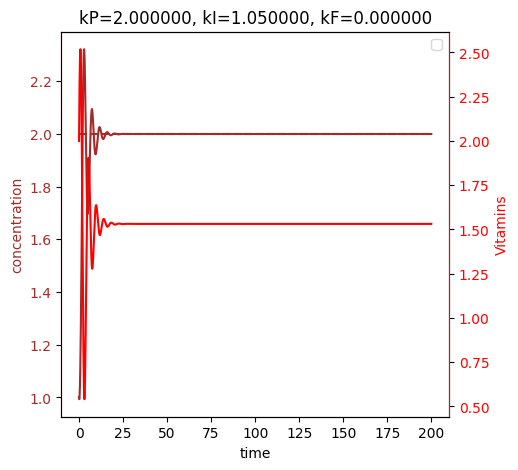

In [13]:
_ = CTLSB.plotDesign(setpoint=2, kP_spec=True, kI_spec=True, min_parameter_value=0.1,
                          num_restart=1, max_parameter_value=2)

## Root locus analysis

### Proportional control

In [14]:
print(f"Transfer function: {TRANSFER_FUNCTION_1}")
print(f"Poles: {TRANSFER_FUNCTION_1.poles()}")
print(f"Zeros: {TRANSFER_FUNCTION_1.zeros()}")

Transfer function: 
             18.54
-------------------------------
6.262e-06 s^2 + 1.978 s + 7.846

Poles: [-3.15920808e+05+0.j -3.96603520e+00+0.j]
Zeros: []


To simplify these poles we will use a built in function:

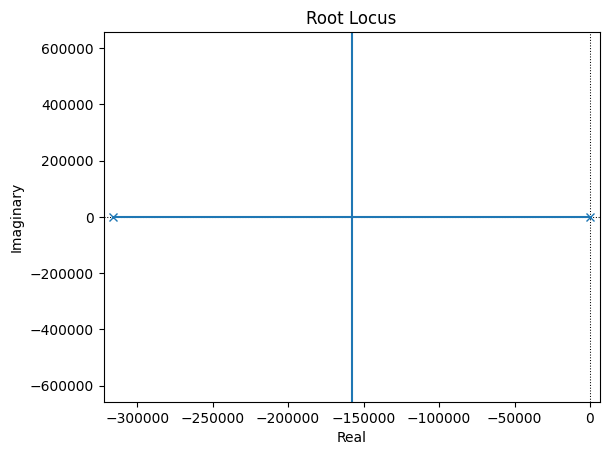

In [15]:
_ = control.root_locus(TRANSFER_FUNCTION_1, grid=False)

We can see that increasing the proportional control will lead to increasing oscillations, although the system will remain stable. In isolation is seems that [0, 1] will be reasonable values of $k_P$ to try.

### Integral control

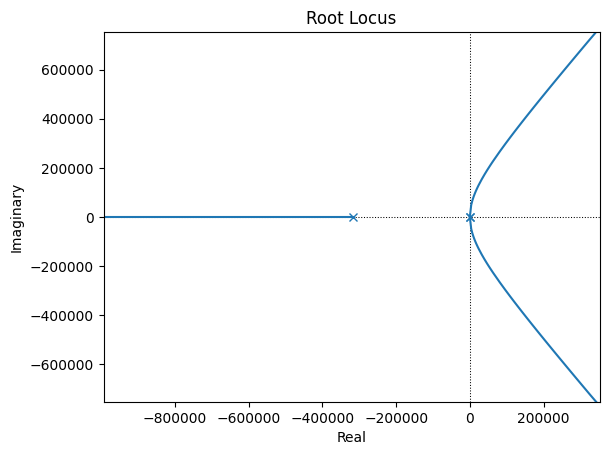

In [16]:
s = control.TransferFunction.s
_ = control.root_locus(TRANSFER_FUNCTION_1/s, grid=False)

Here we can see that there is a small range of values where integral control will keep our system stable, so there isn't a lot of room to improve settling times. In isolation it seems like [0, 1] is a good range to search for $k_I$.

## Grid search

100%|██████████| 9/9 [00:03<00:00,  3.00it/s]


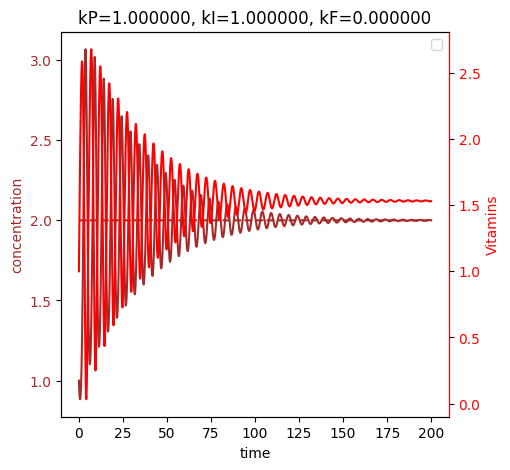

In [17]:
_ = CTLSB.plotDesign(setpoint=2, kP_spec=True, kI_spec=True, min_parameter_value=1,
                max_parameter_value=100, num_restart=1 )

  0%|          | 0/100 [00:00<?, ?it/s]Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 80.4381 and h = 3.61622e-156, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 35.1908 and h = 5.24224e-156, the corrector convergence test failed repeatedly or with |h| = hmin.
  1%|          | 1/100 [00:03<05:09,  3.13s/it]Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 40.7054 and h = 2.12619e-156, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 40.4974 and h = 1.13706e-155, the corrector convergence test failed repeatedly or with |h| = hmin.
 11%|█         | 11/100 [00:04<00:27,  3.23it/s]Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 139.605 and h = 2.19466e-156, the correc

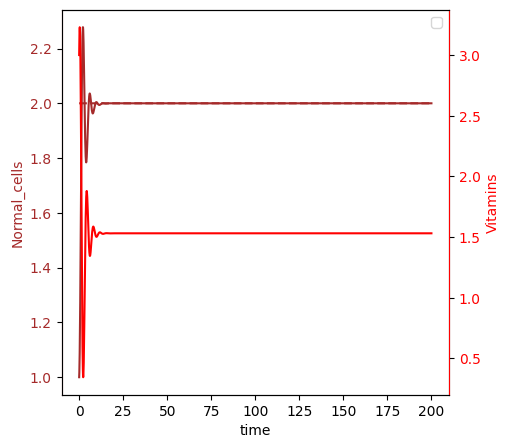

In [18]:
grid = CTLSB.getGrid()
grid.addAxis("kP", min_value=0.1, max_value=3, num_coordinate=10)
grid.addAxis("kI", min_value=0.1, max_value=3, num_coordinate=10)
result = CTLSB.plotGridDesign(grid, setpoint=2, num_restart=1 )

In [19]:
result.designs.dataframe

,kP,score,kI
0,3.000000,0.004016,1.711111
1,3.000000,0.004017,1.388889
2,3.000000,0.004082,2.033333
3,3.000000,0.004155,1.066667
4,3.000000,0.004188,2.355556
...,...,...,...
95,0.744444,NaN,2.033333
96,0.422222,NaN,2.033333
97,0.100000,NaN,0.422222
98,3.000000,NaN,2.677778


Here we see that with $k_P$ = 0.75 and $k_I$ = 0.35 we achieve a relatively good control of the system. The oscilation is not extreme, the vitamin level stays above 0, and the healthy cells converge to a much higher level than the tumor cells. All of the control objectives are met for this system.

# 4. Discussion

Interestingly, this project required a pivot from the original task. Rather than setting out to reduce the number of tumor cells, I rephrased the problem as the converse of maximizing the number of healthy cells. If the goal is to get tumor cells to 0, the systems doesn't administer any vitamins, as the addition of vitamins initially increases the number of tumor cells (although it increases the number of healthy cells more). With this reframing the system has found a resonable vitamin regime that seems to keep healthy cells at a much higher level than tumor cells over the course of the treatment.

Perhaps the most challenging aspect of this project was fitting the transfer function to the OLS, which also happens to be the most important and useful method. Being able to easily to root locus analysis and further downstream analyses on the transfer function was extremely helpful in designing the control parameters.

Another challenge involved keeping the system input (vitamins) above 0 during the design of the control parameters. Although there are perhaps some biological interpretations to negative vitamins, such as actively removing them from the system, for the sake of this process in the system definition I specified they must be kept non-negative. In order to achieve this I had to try some different ranges in which to search through in my grid search for my control parameters, and ended up restricting the bounds to [0, 0.8] as higher parameters would lead to unrealistic solutions.